# Group project: YouTube Trending Videos Analysis

Authors: <br>
Rovan Elgendy <br>
Nikolaos Papanikolaou
<br>

Email: <br>
[rovan.elgendi@gmail.com](mailto:rovan.elgendi@gmail.com) <br>
[ns.papanikolaou1@gmail.com](mailto:ns.papanikolaou1@gmail.com)

### **Project Description:**  
The data chosen for our analysis project is the YouTube Trending Videos Dataset.
It is a collection of datasets for different regions. Each dataset contains one region with the videos that has been trending like DE for Germany, FR for France, GB for Great Britain etc.

The dataset contains columns of video_id, video_title, Channel_title, the number of views, likes, dislikes, comments enabled, number of ccomments, thumbnail link, description, and the date and time the video was trending.

##### In our analysis, we focused only on the region of Germany (DE), but we can easily extend the analysis to other regions by applying the functions we created to clean and transform the data.

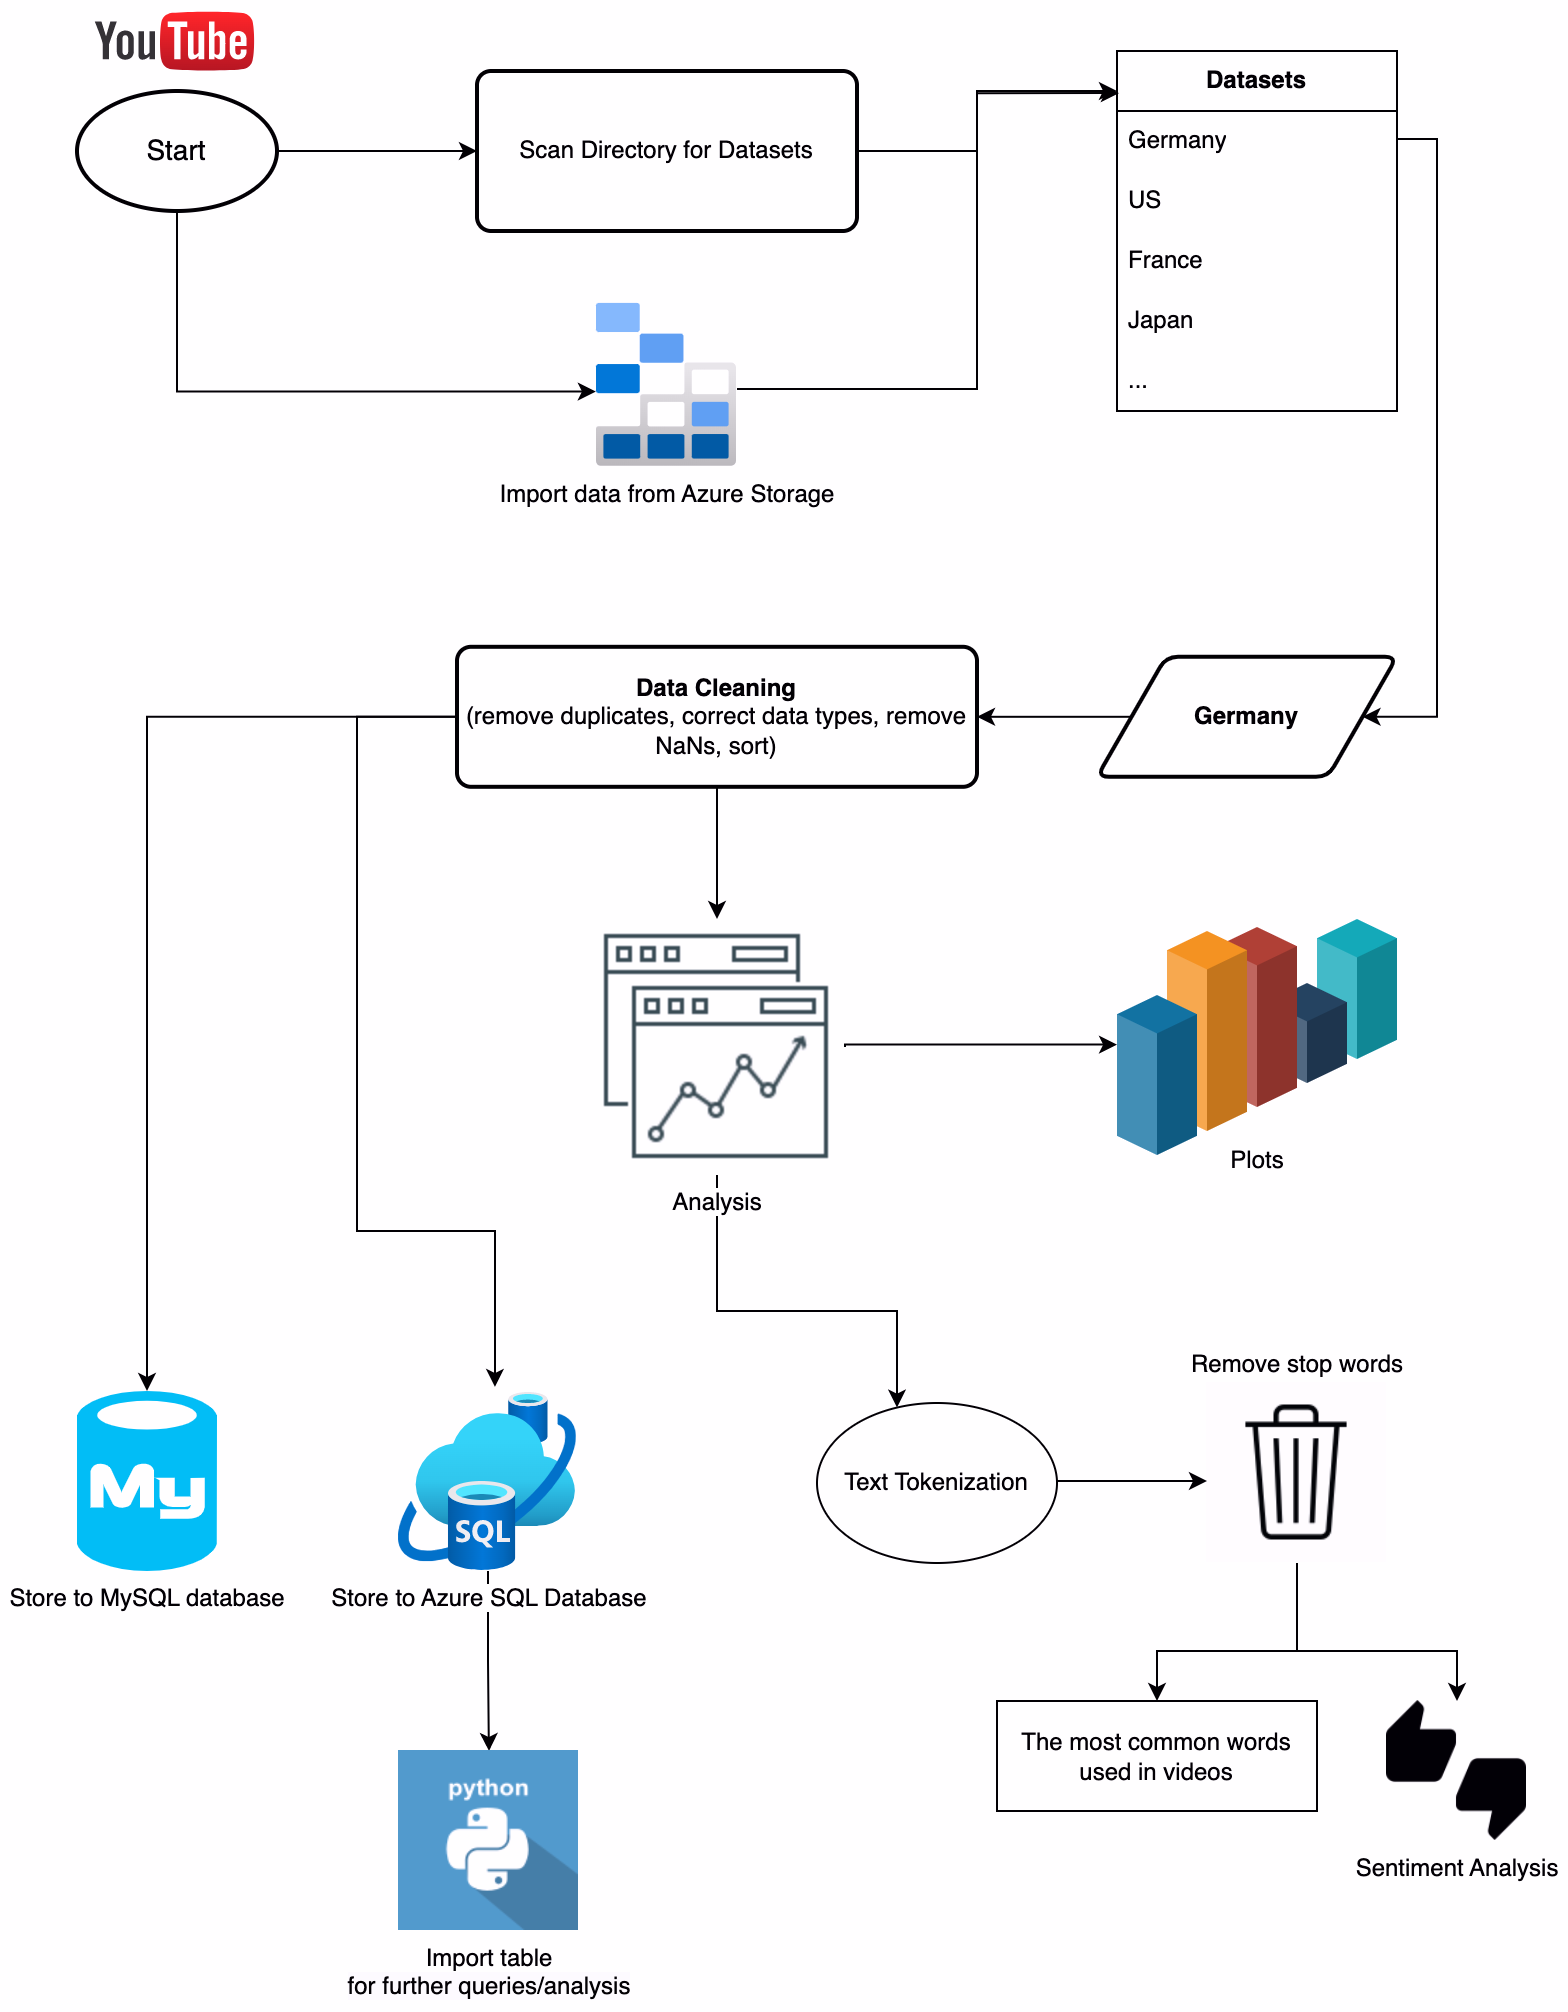

In [ ]:
# Library imports
import pandas as pd
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
from textblob import TextBlob
import os
from azure.storage.blob import BlobServiceClient
import io


# Step 1:  Import data

##### Approach 1:
We can simply download the data using the URL of the file from the azure storage.
The URL of the dataset used here is: https://relgendy.blob.core.windows.net/historicaldata/Project/data%20analysis%20project/DEvideos.csv


##### Approach 2:
We can  have successfully imported the dataset from an Azure container, however, to avoid unwanted charges on Azure we load the dataset from a local file. <br>
The code to load the dataset from Azure is commented out. <br>

From the connection between python and Azure storage by providing the connection string, the dataset code can be run smoothly without downloading the file.

In [ ]:
connection_string = 'DefaultEndpointsProtocol=https;AccountName=relgendy;AccountKey=YTQ1cy1bOeU59C/5cp+Fjk+/DKHvr9LlimYMwuB+IU9yUtMzmvAISJy9SH4sRC9z87AyOM5ZTCyX+AStInnX4g==;EndpointSuffix=core.windows.net'
container_name = 'historicaldata'

blob_service_client = BlobServiceClient.from_connection_string(
    connection_string)
blob_client = blob_service_client.get_blob_client(
    container_name, 'Project/data analysis project/DEvideos.csv')


blob_data = blob_client.download_blob()
data = blob_data.content_as_text()
DE = pd.read_csv(io.StringIO(data))
DE.head()


video_id trending_date  \
0  LgVi6y5QIjM      17.14.11   
1  Bayt7uQith4      17.14.11   
2  1ZAPwfrtAFY      17.14.11   
3  AHtypnRk7JE      17.14.11   
4  ZJ9We4bjcg0      17.14.11   

                                               title            channel_title  \
0  Sing zu Ende! | Gesangseinlagen vom Feinsten |...                inscope21   
1  Kinder ferngesteuert im Kiosk! Erwachsene abzo...  LUKE! Die Woche und ich   
2  The Trump Presidency: Last Week Tonight with J...          LastWeekTonight   
3                                Das Fermi-Paradoxon        100SekundenPhysik   
4           18 SONGS mit Kelly MissesVlog (Sing-off)                     rezo   

   category_id              publish_time  \
0           24  2017-11-13T17:08:49.000Z   
1           23  2017-11-12T22:30:01.000Z   
2           24  2017-11-13T07:30:00.000Z   
3           27  2017-11-12T15:00:01.000Z   
4           24  2017-11-12T13:10:36.000Z   

                                                tags    views   likes  \
0  inscope21|"sing zu ende"|"gesangseinlagen"|"ge...   252786   35885   
1  Kinder|"ferngesteuert"|"Kinder ferngesteuert"|...   797196   53576   
2  last week tonight trump presidency|"last week ...  2418783   97190   
3  Physik|"Wissenschaft"|"Technik"|"Science-Ficti...   380247   31821   
4  kelly|"missesvlog"|"kelly song"|"bausa"|"bausa...   822213  100684   

   dislikes  comment_count                                  thumbnail_link  \
0       230           1539  https://i.ytimg.com/vi/LgVi6y5QIjM/default.jpg   
1       302           1278  https://i.ytimg.com/vi/Bayt7uQith4/default.jpg   
2      6146          12703  https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg   
3       458           1955  https://i.ytimg.com/vi/AHtypnRk7JE/default.jpg   
4      2467          10244  https://i.ytimg.com/vi/ZJ9We4bjcg0/default.jpg   

   comments_disabled  ratings_disabled  video_error_or_removed  \
0              False             False                   False   
1              False             False                   False   
2              False             False                   False   
3              False             False                   False   
4              False             False                   False   

                                         description  
0  Heute gibt es mal wieder ein neues Format... w...  
1  Kinder ferngesteuert! Kinder lassen sich sooo ...  
2  One year after the presidential election, John...  
3  ‚ñ∫Alle Videos: http://bit.ly/1fa7Tw3\n\n\n‚úöSnap...  
4  18 Song Mashup √ºber den (ver√§nderten) Beat von...

##### Approach 3:
 We can also import all datasets automatically in a local directory and create a separate pandas dataframe for each dataset which is dynamically named. <br>


In [ ]:
# List files in the input directory
%ls data/youtube_data


CA_category_id.json  GBvideos.csv         MX_category_id.json
CAvideos.csv         IN_category_id.json  MXvideos.csv
DE_category_id.json  INvideos.csv         RU_category_id.json
DEvideos.csv         JP_category_id.json  RUvideos.csv
FR_category_id.json  JPvideos.csv         US_category_id.json
FRvideos.csv         KR_category_id.json  USvideos.csv
GB_category_id.json  KRvideos.csv


In [ ]:
directory = 'data/youtube_data'
datasets = []  # List of dataset paths

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        datasets.append(os.path.join(directory, filename))
        print(os.path.join(directory, filename))
    elif filename.endswith(".json"):
        continue


data/youtube_data/MXvideos.csv
data/youtube_data/INvideos.csv
data/youtube_data/DEvideos.csv
data/youtube_data/JPvideos.csv
data/youtube_data/KRvideos.csv
data/youtube_data/CAvideos.csv
data/youtube_data/RUvideos.csv
data/youtube_data/FRvideos.csv
data/youtube_data/USvideos.csv
data/youtube_data/GBvideos.csv


In [ ]:
# We will create a dictionary to store the DataFrames. We can call each DataFrame by its country code.

# Function to read CSV files and return DataFrames
def read_csv_to_dataframe(file_path):
    return pd.read_csv(file_path, encoding='ISO-8859-1')


# Dictionary to store DataFrames with their respective names
dataframes = {}

# Loop through the dataset paths and read them into separate DataFrames
for dataset in datasets:
    country_code = os.path.basename(dataset).split("videos.csv")[0].upper()
    dataframes[country_code] = read_csv_to_dataframe(dataset)

# Dynamically create variables for each country code
for country_code, dataframe in dataframes.items():
    globals()[country_code] = dataframe


In [ ]:
# For our analysis we will continue with the German dataset
# DE = dataframes['DE']

# For convenience we can also just read in a single CSV file
# the directory is 'data/youtube_data'
DE = pd.read_csv('data/youtube_data/DEvideos.csv')


### Profiling
We can take a quick look at a dataset using the profiling function. The profile will give us a quick overview of the dataset and the number of missing values in each column, the data type of each column and the number of unique values in each column etc. <br> 
We have commented it out since it needs a older version of python. <br>
The library needs python 3.10 or lower to run.
We ran in to create the profile report but we do not need to run it again since the output is already saved in the folder as profile.html. We can open it using any browser. <br>

In [ ]:
# Needs python version <3.11
# df_raw = US
# !pip install ydata_profiling
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df_raw, title='Pandas Profiling Report', explorative=True)
# profile.to_file(output_file="profile.html")
# profile.to_widgets()


# Step2: Function definitions for Data Cleaning

In [ ]:
def remove_duplicates(df):
    '''Remove duplicate rows from the dataframe based on all columns'''
    df.drop_duplicates(keep='first', inplace=True)
    return df


def remove_nan_rows(dataframe, threshold=5):
    '''Remove rows with more than threshold number of NaN values'''
    num_nan_values = dataframe.isna().sum(axis=1)
    rows_to_remove = num_nan_values > threshold
    dataframe = dataframe.loc[~rows_to_remove, :]
    return dataframe


def adjust_datetime_format(dataframe):
    '''Adjust the format of the trending_date and publish_time columns'''
    dataframe['trending_date'] = pd.to_datetime(
        dataframe['trending_date'], format='%y.%d.%m')
    dataframe['publish_time'] = pd.to_datetime(dataframe['publish_time'])
    return dataframe


def set_index_and_sort(dataframe):
    '''Set the index of the dataframe to the publish_time column and sort the dataframe by the index'''
    dataframe.set_index('publish_time', inplace=True)
    dataframe.sort_index(ascending=True, inplace=True)
    return dataframe


The clean() function cleans the dataset once we import it successfully with pandas/Azure connection. <br>
The function takes the dataset as an input and returns the cleaned dataset. <br>
It performs the following steps
-  remove duplicated rows
- remove rows where there are NaN values in more than 5 columns
- set the datatype (dtype) of the dates to datetime format
- set the publish time as index and sort the dataset according to the index (ascending order of dates)

In [ ]:
def clean(dataframe):
    print('The dataframe shape is: ', dataframe.shape)
    print('Starting data cleaning: detect duplicated rows, NaN values, adjust the dtype for dates,\n'
          'set an index and sort the dataframe based on the publish time in ascending order.')

    duplicate_rows = dataframe.duplicated()
    num_duplicate_rows = duplicate_rows.sum()
    print("Number of duplicate rows: ", num_duplicate_rows)

    if num_duplicate_rows > 0:
        dataframe = remove_duplicates(dataframe)
        print('Now the dataframe shape is: ', dataframe.shape)
    else:
        print('No duplicated rows to remove')

    print('Now to check the NaN values.')
    print(dataframe.isna().sum(axis=1))

    dataframe = remove_nan_rows(dataframe, threshold=5)
    print('After removing the NaN values from a row that has more than 5 columns with NaN values.', dataframe.shape)

    print('The publish time and trending date need to be adjusted to datetime format..\n',
          'Their dtypes before adjustment are:', dataframe['publish_time'].dtype, dataframe['trending_date'].dtype)

    dataframe = adjust_datetime_format(dataframe)
    print('After adjustment the publish time dtype is: ',
          dataframe['publish_time'].dtype, 'and trending_date dtype is:', dataframe['trending_date'].dtype)

    print('Setting the publish time as index and to be sorted in ascending order of dates.')
    set_index_and_sort(dataframe)

    return dataframe


In [ ]:
DE = clean(DE)  # Clean the dataframe for Germany


The dataframe shape is:  (40840, 16)
Starting data cleaning: detect duplicated rows, NaN values, adjust the dtype for dates,
set an index and sort the dataframe based on the publish time in ascending order.
Number of duplicate rows:  0
No duplicated rows to remove
Now to check the NaN values.
0        0
1        0
2        0
3        0
4        0
        ..
40835    0
40836    0
40837    0
40838    0
40839    0
Length: 40840, dtype: int64
After removing the NaN values from a row that has more than 5 columns with NaN values. (40840, 16)
The publish time and trending date need to be adjusted to datetime format..
 Their dtypes before adjustment are: object object
After adjustment the publish time dtype is:  datetime64[ns, UTC] and trending_date dtype is: datetime64[ns]
Setting the publish time as index and to be sorted in ascending order of dates


In [ ]:
DE.head()


video_id trending_date  \
publish_time                                           
2012-04-18 10:58:15+00:00  FXA937WRDk0    2017-11-24   
2014-01-19 23:13:43+00:00  -qdeWp22Rzo    2018-01-26   
2014-01-29 14:17:52+00:00  maU5rLgMvWI    2018-01-31   
2014-01-29 14:17:52+00:00  maU5rLgMvWI    2018-01-30   
2014-05-22 20:04:27+00:00  45L82cOjfY0    2018-02-06   

                                                                       title  \
publish_time                                                                   
2012-04-18 10:58:15+00:00  Kriminelle Gro√üfamilien in Berlin - Interview ...   
2014-01-19 23:13:43+00:00                  Wrigley's Doublemint Werbung 1992   
2014-01-29 14:17:52+00:00                      Garish - Bring mich auf Ideen   
2014-01-29 14:17:52+00:00                      Garish - Bring mich auf Ideen   
2014-05-22 20:04:27+00:00  Hey Brother performed by Dan Tyminski and Jerr...   

                                  channel_title  category_id  \
publish_time                                                   
2012-04-18 10:58:15+00:00  GehirnerweichungNein           25   
2014-01-19 23:13:43+00:00            RetroSpots            1   
2014-01-29 14:17:52+00:00                  OMhA           10   
2014-01-29 14:17:52+00:00                  OMhA           10   
2014-05-22 20:04:27+00:00            Alex Lewis           10   

                                                                        tags  \
publish_time                                                                   
2012-04-18 10:58:15+00:00  Intensivt√§ter|"Islamisierung"|"T√ºrken"|"Berlin...   
2014-01-19 23:13:43+00:00  Werbung|"TV spot"|"Werbespot"|"commercial"|"pu...   
2014-01-29 14:17:52+00:00  Garish Trumpf|"Garish"|"Trumpf"|"Bring mich au...   
2014-01-29 14:17:52+00:00  Garish Trumpf|"Garish"|"Trumpf"|"Bring mich au...   
2014-05-22 20:04:27+00:00  Hey Brother|"Dan Tyminski (Record Producer)"|"...   

                           views  likes  dislikes  comment_count  \
publish_time                                                       
2012-04-18 10:58:15+00:00  11373     90         1              6   
2014-01-19 23:13:43+00:00   2825     25         0             10   
2014-01-29 14:17:52+00:00  54824    266         9             11   
2014-01-29 14:17:52+00:00  51278    225         9              8   
2014-05-22 20:04:27+00:00  99463    496        13             24   

                                                           thumbnail_link  \
publish_time                                                                
2012-04-18 10:58:15+00:00  https://i.ytimg.com/vi/FXA937WRDk0/default.jpg   
2014-01-19 23:13:43+00:00  https://i.ytimg.com/vi/-qdeWp22Rzo/default.jpg   
2014-01-29 14:17:52+00:00  https://i.ytimg.com/vi/maU5rLgMvWI/default.jpg   
2014-01-29 14:17:52+00:00  https://i.ytimg.com/vi/maU5rLgMvWI/default.jpg   
2014-05-22 20:04:27+00:00  https://i.ytimg.com/vi/45L82cOjfY0/default.jpg   

                           comments_disabled  ratings_disabled  \
publish_time                                                     
2012-04-18 10:58:15+00:00              False             False   
2014-01-19 23:13:43+00:00              False             False   
2014-01-29 14:17:52+00:00              False             False   
2014-01-29 14:17:52+00:00              False             False   
2014-05-22 20:04:27+00:00              False             False   

                           video_error_or_removed  \
publish_time                                        
2012-04-18 10:58:15+00:00                   False   
2014-01-19 23:13:43+00:00                   False   
2014-01-29 14:17:52+00:00                   False   
2014-01-29 14:17:52+00:00                   False   
2014-05-22 20:04:27+00:00                   False   

                                                                 description  
publish_time                                                                  
2012-04-18 10:58:15+00:00  Arnold Mengelkoch wird in 

In [ ]:
DE.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40840 entries, 2012-04-18 10:58:15+00:00 to 2018-06-14 00:33:42+00:00
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   video_id                40840 non-null  object        
 1   trending_date           40840 non-null  datetime64[ns]
 2   title                   40840 non-null  object        
 3   channel_title           40840 non-null  object        
 4   category_id             40840 non-null  int64         
 5   tags                    40840 non-null  object        
 6   views                   40840 non-null  int64         
 7   likes                   40840 non-null  int64         
 8   dislikes                40840 non-null  int64         
 9   comment_count           40840 non-null  int64         
 10  thumbnail_link          40840 non-null  object        
 11  comments_disabled       40840 non-null  bool          
 12 

In [ ]:
DE.describe(include='all')


/var/folders/5l/8z4lqvmn5_n_x15dq00rzt400000gn/T/ipykernel_65047/2129482434.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  DE.describe(include='all')


video_id        trending_date  \
count         40840                40840   
unique        29627                  205   
top     pk0iqFne5eU  2017-11-24 00:00:00   
freq              7                  200   
first           NaN  2017-11-14 00:00:00   
last            NaN  2018-06-14 00:00:00   
mean            NaN                  NaN   
std             NaN                  NaN   
min             NaN                  NaN   
25%             NaN                  NaN   
50%             NaN                  NaN   
75%             NaN                  NaN   
max             NaN                  NaN   

                                                  title channel_title  \
count                                             40840         40840   
unique                                            29682          6085   
top     Nur 2% aller Menschen schaffen diese 5 R√§tsel..       Galileo   
freq                                                 20           200   
first                                               NaN           NaN   
last                                                NaN           NaN   
mean                                                NaN           NaN   
std                                                 NaN           NaN   
min                                                 NaN           NaN   
25%                                                 NaN           NaN   
50%                                                 NaN           NaN   
75%                                                 NaN           NaN   
max                                                 NaN           NaN   

         category_id    tags         views         likes      dislikes  \
count   40840.000000   40840  4.084000e+04  4.084000e+04  4.084000e+04   
unique           NaN   23557           NaN           NaN           NaN   
top              NaN  [none]           NaN           NaN           NaN   
freq             NaN    3031           NaN           NaN           NaN   
first            NaN     NaN           NaN           NaN           NaN   
last             NaN     NaN           NaN           NaN           NaN   
mean       20.705828     NaN  6.034553e+05  2.187550e+04  1.397136e+03   
std         6.975813     NaN  2.348963e+06  1.018000e+05  1.457738e+04   
min         1.000000     NaN  5.180000e+02  0.000000e+00  0.000000e+00   
25%        20.000000     NaN  2.706875e+04  5.330000e+02  2.900000e+01   
50%        24.000000     NaN  1.192770e+05  2.699000e+03  1.340000e+02   
75%        24.000000     NaN  4.431015e+05  1.179625e+04  5.320000e+02   
max        44.000000     NaN  1.138762e+08  4.924056e+06  1.470386e+06   

        comment_count                                  thumbnail_link  \
count    4.084000e+04                                           40840   
unique            NaN                                           29626   
top               NaN  https://i.ytimg.com/vi/pk0iqFne5eU/default.jpg   
freq              NaN                                               7   
first             NaN                                             NaN   
last              NaN                                             NaN   
mean     2.785857e+03                                             NaN   
std      1.745803e+04                                             NaN   
min      0.000000e+00                                             NaN   
25%      7.900000e+01                                             NaN   
50%      3.760000e+02                                             NaN   
75%      1.376000e+03                                             NaN   
max      1.084435e+06                                             NaN   

       comments_disabled ratings_disabled video_error_or_removed  \
count              40840            40840                  40840   
unique                 2                2                      2   
top                False            False                  False   
freq               39796            40

# Step 3: Data Visualization

Our analysis aims to explore various aspects of video popularity on a social media platform. Objectives include investigating the correlation between the number of views and likes by calculating r-value and p-value, as well as examining the same relationship using mean views and likes per video for comparison. The research will also determine the time it takes for a video to become trendy by calculating the number of days between the publishing time and the trendy dates. Additionally, the study will identify which category boasts the most popular views and likes, and rank the top 5 channels with the most views and the top 5 channels with the most likes.

<Axes: xlabel='views', ylabel='likes'>

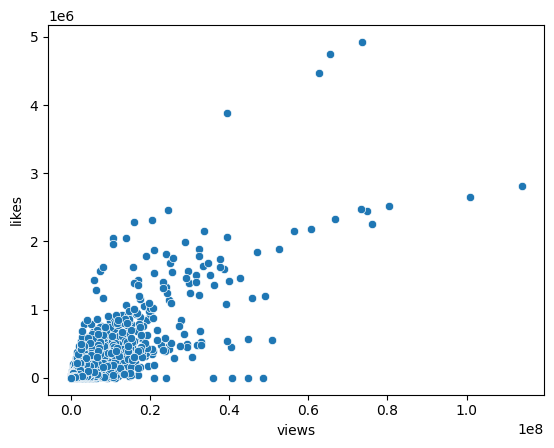

In [ ]:
# We plot a scatterplot to see if there is any correlation between the number of views and likes
sns.scatterplot(x='views', y='likes', data=DE)


In [ ]:
# We calculate the Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(DE['views'], DE['likes'])
# 0.824 which gives positive correlation; means that when the number of views increase , the no. of likes increase
print("Pearson correlation coefficient:", pearson_corr)
# 0.0 means that the statistics here is significant and didn't occur by chance
print("p-value:", p_value)


Pearson correlation coefficient: 0.8241886774194309
p-value: 0.0


In [ ]:
# We show the mean number of views, likes, dislikes, comments per video id
mean_data = DE.groupby('video_id')[
    ['views', 'likes', 'dislikes', 'comment_count']].mean()
mean_data


views         likes     dislikes  comment_count
video_id                                                           
--7vNbh4UNA  1.082647e+06  52113.000000  1284.000000        10602.0
--I0aj8MUdU  1.182765e+05    436.000000    68.500000           18.5
--MtKsH5oBY  3.680030e+05   2836.000000   299.500000          664.5
--moh3hSPpY  1.705000e+04    100.000000    32.000000           74.0
--rE6D0_jAw  5.406000e+03    964.000000     4.000000          191.0
...                   ...           ...          ...            ...
zyzuut5pZDg  5.829495e+05   4422.000000   120.500000          196.5
zz-RpiUFY-I  1.410140e+05   9243.000000   193.500000         1466.5
zz2ZSsUUbFs  1.327600e+04     99.500000     8.000000           10.5
zzHW6gJG7W0  4.757527e+05  28819.333333   845.333333         1075.0
zzokx9oX77k  5.798000e+03    309.000000    15.000000           60.0

[29627 rows x 4 columns]

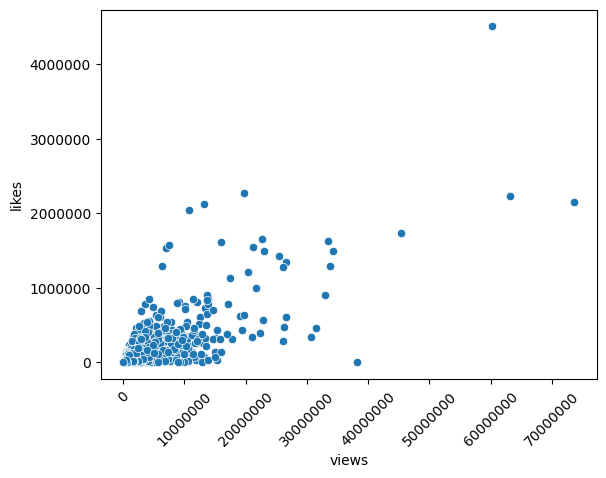

In [ ]:
# We plot a scatter plot of mean views vs. mean likes
sns.scatterplot(data=mean_data, x=mean_data['views'], y=mean_data['likes'])

# Set the tick label format to plain (no scientific notation)
plt.ticklabel_format(style='plain', axis='both')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# We check the r-value and p-value using the mean data to check if the statistics are to be trusted as well
# We calculate Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(mean_data['views'], mean_data['likes'])
# 0.787 which implies a positive correlation. This means that when the number of views increase, the number of likes increase also.
print("Pearson correlation coefficient:", pearson_corr)
# 0.0 means that the statistics here is significant and didn't occur by chance
print("p-value:", p_value)


Pearson correlation coefficient: 0.7876647227761039
p-value: 0.0


We want to investigate how much time it takes for a video to become trending as soon as it gets published, by calculating the number of days between the publishing time and the trending dates.

In [ ]:
# DE['days_to_trending'] = (DE['trending_date'] - DE.index).dt.days # We get an error as the trending date doesn't have time zone so we need to add it and make both with the same timezone
# localize the datetime objects to 'Europe/Berlin' timezone
DE['trending_date'] = DE['trending_date'].dt.tz_localize('UTC')
# For clarity we convert to the timezone we want in a septate line
DE['trending_date'] = DE['trending_date'].dt.tz_convert('Europe/Berlin')
DE.index = DE.index.tz_convert('Europe/Berlin')


In [ ]:
# We calculate the number of days from the publish time to the trending date
DE['days_to_trending'] = (DE['trending_date'] - DE.index).dt.days
DE.head()


video_id             trending_date  \
publish_time                                                       
2012-04-18 12:58:15+02:00  FXA937WRDk0 2017-11-24 01:00:00+01:00   
2014-01-20 00:13:43+01:00  -qdeWp22Rzo 2018-01-26 01:00:00+01:00   
2014-01-29 15:17:52+01:00  maU5rLgMvWI 2018-01-31 01:00:00+01:00   
2014-01-29 15:17:52+01:00  maU5rLgMvWI 2018-01-30 01:00:00+01:00   
2014-05-22 22:04:27+02:00  45L82cOjfY0 2018-02-06 01:00:00+01:00   

                                                                       title  \
publish_time                                                                   
2012-04-18 12:58:15+02:00  Kriminelle Gro√üfamilien in Berlin - Interview ...   
2014-01-20 00:13:43+01:00                  Wrigley's Doublemint Werbung 1992   
2014-01-29 15:17:52+01:00                      Garish - Bring mich auf Ideen   
2014-01-29 15:17:52+01:00                      Garish - Bring mich auf Ideen   
2014-05-22 22:04:27+02:00  Hey Brother performed by Dan Tyminski and Jerr...   

                                  channel_title  category_id  \
publish_time                                                   
2012-04-18 12:58:15+02:00  GehirnerweichungNein           25   
2014-01-20 00:13:43+01:00            RetroSpots            1   
2014-01-29 15:17:52+01:00                  OMhA           10   
2014-01-29 15:17:52+01:00                  OMhA           10   
2014-05-22 22:04:27+02:00            Alex Lewis           10   

                                                                        tags  \
publish_time                                                                   
2012-04-18 12:58:15+02:00  Intensivt√§ter|"Islamisierung"|"T√ºrken"|"Berlin...   
2014-01-20 00:13:43+01:00  Werbung|"TV spot"|"Werbespot"|"commercial"|"pu...   
2014-01-29 15:17:52+01:00  Garish Trumpf|"Garish"|"Trumpf"|"Bring mich au...   
2014-01-29 15:17:52+01:00  Garish Trumpf|"Garish"|"Trumpf"|"Bring mich au...   
2014-05-22 22:04:27+02:00  Hey Brother|"Dan Tyminski (Record Producer)"|"...   

                           views  likes  dislikes  comment_count  \
publish_time                                                       
2012-04-18 12:58:15+02:00  11373     90         1              6   
2014-01-20 00:13:43+01:00   2825     25         0             10   
2014-01-29 15:17:52+01:00  54824    266         9             11   
2014-01-29 15:17:52+01:00  51278    225         9              8   
2014-05-22 22:04:27+02:00  99463    496        13             24   

                                                           thumbnail_link  \
publish_time                                                                
2012-04-18 12:58:15+02:00  https://i.ytimg.com/vi/FXA937WRDk0/default.jpg   
2014-01-20 00:13:43+01:00  https://i.ytimg.com/vi/-qdeWp22Rzo/default.jpg   
2014-01-29 15:17:52+01:00  https://i.ytimg.com/vi/maU5rLgMvWI/default.jpg   
2014-01-29 15:17:52+01:00  https://i.ytimg.com/vi/maU5rLgMvWI/default.jpg   
2014-05-22 22:04:27+02:00  https://i.ytimg.com/vi/45L82cOjfY0/default.jpg   

                           comments_disabled  ratings_disabled  \
publish_time                                                     
2012-04-18 12:58:15+02:00              False             False   
2014-01-20 00:13:43+01:00              False             False   
2014-01-29 15:17:52+01:00              False             False   
2014-01-29 15:17:52+01:00              False             False   
2014-05-22 22:04:27+02:00              False             False   

                           video_error_or_removed  \
publish_time                                        
2012-04-18 12:58:15+02:00                   False   
2014-01-20 00:13:43+01:00                   False   
2014-01-29 15:17:52+01:00                   False   
2014-01-29 15:17:52+01:00                   False   
2014-05-22 22:04:27+02:00                   False   

                                                                 description  \
publish_time                                   

We show a scatter plot of the number of days between the publishing time and the trending dates for each video. We can see that most of the videos are trending within 10 days of publishing. However, there are some videos that are trending after 100 days of publishing. Before 2018 it took much more time for a video to become trending. After 2018, the number of days between the publishing time and the trending dates is much lower. This is probably due to the fact that YouTube is becoming more popular and more people are using it in Germany. Therefore, it is easier for a video to become trending.

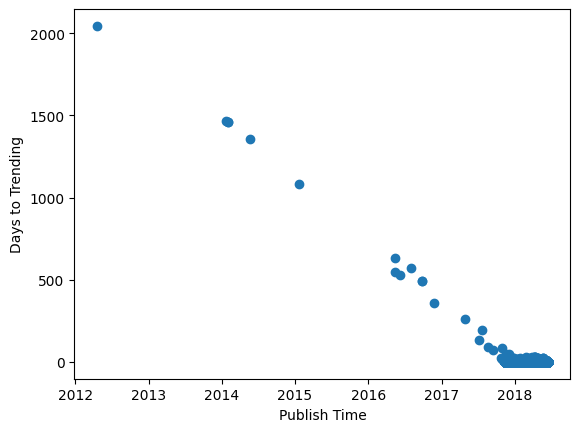

In [ ]:
plt.scatter(DE.index, DE['days_to_trending'])
plt.xlabel('Publish Time')
plt.ylabel('Days to Trending')
plt.show()


Next, we want to investigate the correlation between the number of views and days_to_trending by calculating r-value and p-value. We don't see a strong correlation between the number of views and days_to_trending. The r-value is 0.0065 and the p-value is 0.18. This means that there is a weak positive correlation between the number of views and days_to_trending, but the p-value is 0.18 which means that the correlation is not statistically significant.

In [ ]:
# We check the r-value and p-value using the mean data to check if the statistics are to be trusted as well
# Calculate Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(DE['views'], DE['days_to_trending'])
print("Pearson correlation coefficient:", pearson_corr)
print("p-value:", p_value)


Pearson correlation coefficient: 0.006585052842674078
p-value: 0.18327423862281755


In [ ]:
DE.head()


video_id             trending_date  \
publish_time                                                       
2012-04-18 12:58:15+02:00  FXA937WRDk0 2017-11-24 01:00:00+01:00   
2014-01-20 00:13:43+01:00  -qdeWp22Rzo 2018-01-26 01:00:00+01:00   
2014-01-29 15:17:52+01:00  maU5rLgMvWI 2018-01-31 01:00:00+01:00   
2014-01-29 15:17:52+01:00  maU5rLgMvWI 2018-01-30 01:00:00+01:00   
2014-05-22 22:04:27+02:00  45L82cOjfY0 2018-02-06 01:00:00+01:00   

                                                                       title  \
publish_time                                                                   
2012-04-18 12:58:15+02:00  Kriminelle Gro√üfamilien in Berlin - Interview ...   
2014-01-20 00:13:43+01:00                  Wrigley's Doublemint Werbung 1992   
2014-01-29 15:17:52+01:00                      Garish - Bring mich auf Ideen   
2014-01-29 15:17:52+01:00                      Garish - Bring mich auf Ideen   
2014-05-22 22:04:27+02:00  Hey Brother performed by Dan Tyminski and Jerr...   

                                  channel_title  category_id  \
publish_time                                                   
2012-04-18 12:58:15+02:00  GehirnerweichungNein           25   
2014-01-20 00:13:43+01:00            RetroSpots            1   
2014-01-29 15:17:52+01:00                  OMhA           10   
2014-01-29 15:17:52+01:00                  OMhA           10   
2014-05-22 22:04:27+02:00            Alex Lewis           10   

                                                                        tags  \
publish_time                                                                   
2012-04-18 12:58:15+02:00  Intensivt√§ter|"Islamisierung"|"T√ºrken"|"Berlin...   
2014-01-20 00:13:43+01:00  Werbung|"TV spot"|"Werbespot"|"commercial"|"pu...   
2014-01-29 15:17:52+01:00  Garish Trumpf|"Garish"|"Trumpf"|"Bring mich au...   
2014-01-29 15:17:52+01:00  Garish Trumpf|"Garish"|"Trumpf"|"Bring mich au...   
2014-05-22 22:04:27+02:00  Hey Brother|"Dan Tyminski (Record Producer)"|"...   

                           views  likes  dislikes  comment_count  \
publish_time                                                       
2012-04-18 12:58:15+02:00  11373     90         1              6   
2014-01-20 00:13:43+01:00   2825     25         0             10   
2014-01-29 15:17:52+01:00  54824    266         9             11   
2014-01-29 15:17:52+01:00  51278    225         9              8   
2014-05-22 22:04:27+02:00  99463    496        13             24   

                                                           thumbnail_link  \
publish_time                                                                
2012-04-18 12:58:15+02:00  https://i.ytimg.com/vi/FXA937WRDk0/default.jpg   
2014-01-20 00:13:43+01:00  https://i.ytimg.com/vi/-qdeWp22Rzo/default.jpg   
2014-01-29 15:17:52+01:00  https://i.ytimg.com/vi/maU5rLgMvWI/default.jpg   
2014-01-29 15:17:52+01:00  https://i.ytimg.com/vi/maU5rLgMvWI/default.jpg   
2014-05-22 22:04:27+02:00  https://i.ytimg.com/vi/45L82cOjfY0/default.jpg   

                           comments_disabled  ratings_disabled  \
publish_time                                                     
2012-04-18 12:58:15+02:00              False             False   
2014-01-20 00:13:43+01:00              False             False   
2014-01-29 15:17:52+01:00              False             False   
2014-01-29 15:17:52+01:00              False             False   
2014-05-22 22:04:27+02:00              False             False   

                           video_error_or_removed  \
publish_time                                        
2012-04-18 12:58:15+02:00                   False   
2014-01-20 00:13:43+01:00                   False   
2014-01-29 15:17:52+01:00                   False   
2014-01-29 15:17:52+01:00                   False   
2014-05-22 22:04:27+02:00                   False   

                                                                 description  \
publish_time                                   

Now, we take a look at the monthly average number of days until a video becomes trending only for the year 2018 and after. We see that the average number of days is even less than a day.

/var/folders/5l/8z4lqvmn5_n_x15dq00rzt400000gn/T/ipykernel_65047/531858991.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DE_monthly = DE_2018.resample('M').mean()


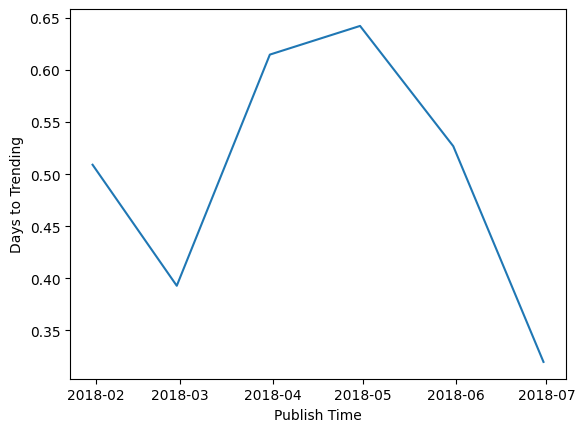

In [ ]:
DE_2018 = DE[DE.index.year >= 2018]
DE_monthly = DE_2018.resample('M').mean()
plt.plot(DE_monthly['days_to_trending'], '-')
# plt.scatter(DE_monthly.index, DE_monthly['days_to_trending']) # option 2
plt.xlabel('Publish Time')
plt.ylabel('Days to Trending')
plt.show()


We see that we have weak negative correlation but the p-value is 0.65 which means that the correlation is not statistically significant.

In [ ]:
# We check the r-value and p-value using the mean data to check if the statistics are significant
# We calculate the Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(
    DE_monthly['views'], DE_monthly['days_to_trending'])
print("Pearson correlation coefficient:", pearson_corr)  # negative correlation
# 0.65 which implies that the correlation is not significant
print("p-value:", p_value)


Pearson correlation coefficient: -0.23699136293995313
p-value: 0.6511682544140511


### Category Analysis
Futhermore, we want to know which category has the most popular video by views and likes.
We will group our data by category_id and calculate sum of views and likes per category_id. <br>
We import the DE.JSON File which contains the category title with its id and merge it with the original dataset which contains only the category_id.

##### Approach 1:
We can use the azure storage connection to python, to download and read the JSON file.

In [ ]:
from azure.storage.blob import BlobClient
import json
import io
connection_string = 'DefaultEndpointsProtocol=https;AccountName=relgendy;AccountKey=YTQ1cy1bOeU59C/5cp+Fjk+/DKHvr9LlimYMwuB+IU9yUtMzmvAISJy9SH4sRC9z87AyOM5ZTCyX+AStInnX4g==;EndpointSuffix=core.windows.net'
container_name = 'historicaldata'
blob_name = 'Project/data analysis project/DE_category_id.json'

blob_client = BlobClient.from_connection_string(
    connection_string, container_name, blob_name)

with blob_client:
    blob_data = blob_client.download_blob()
    data = blob_data.content_as_text()
    categories = json.loads(data)


##### Approach 2:
Download the JSON file using the URL from Azure storage

The JSON file containing the category titles for each category id is: <br>
https://relgendy.blob.core.windows.net/historicaldata/Project/data%20analysis%20project/DE_category_id.json

##### Approach 3 :

We can also simply import the JSON file from a local directory.

In [ ]:
# Import the json file from the local directory
with open('data/youtube_data/DE_category_id.json', 'r') as f:
    categories = json.load(f)


In [ ]:
# Create a DataFrame with category ID and category title
categories_df = pd.DataFrame([(c['id'], c['snippet']['title']) for c in categories['items']],
                             columns=['category_id', 'category_title'])

categories_df

category_id        category_title
0            1      Film & Animation
1            2      Autos & Vehicles
2           10                 Music
3           15        Pets & Animals
4           17                Sports
5           18          Short Movies
6           19       Travel & Events
7           20                Gaming
8           21         Videoblogging
9           22        People & Blogs
10          23                Comedy
11          24         Entertainment
12          25       News & Politics
13          26         Howto & Style
14          27             Education
15          28  Science & Technology
16          30                Movies
17          31       Anime/Animation
18          32      Action/Adventure
19          33              Classics
20          34                Comedy
21          35           Documentary
22          36                 Drama
23          37                Family
24          38               Foreign
25          39                Horror
26          40        Sci-Fi/Fantasy
27          41              Thriller
28          42                Shorts
29          43                 Shows
30          44              Trailers

In [ ]:
categories_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   category_id     31 non-null     object
 1   category_title  31 non-null     object
dtypes: object(2)
memory usage: 628.0+ bytes


In [ ]:
DE.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40840 entries, 2012-04-18 12:58:15+02:00 to 2018-06-14 02:33:42+02:00
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype                        
---  ------                  --------------  -----                        
 0   video_id                40840 non-null  object                       
 1   trending_date           40840 non-null  datetime64[ns, Europe/Berlin]
 2   title                   40840 non-null  object                       
 3   channel_title           40840 non-null  object                       
 4   category_id             40840 non-null  int64                        
 5   tags                    40840 non-null  object                       
 6   views                   40840 non-null  int64                        
 7   likes                   40840 non-null  int64                        
 8   dislikes                40840 non-null  int64                        
 9   comment_count 

In [ ]:
# We change the data type of the category_id column to int
categories_df['category_id'] = categories_df['category_id'].astype('int')

In [ ]:
# We cannot merge the two dataframes as the category_id column is of different data types
# merged_df = DE.merge(categories_df, left_on='category_id', right_index=True) # ERROR
# Again, we change the data type of the category_id column to int for the DE dataframe
DE['category_id'] = DE['category_id'].astype('int')

In [ ]:
# Finally, we merge the two dataframes by on the category_id column
merged = DE.merge(categories_df, on='category_id')

In [ ]:
# We take a look at the merged dataframe and see that the merge was successful and the category_title column was added
merged.head(3)

video_id             trending_date  \
0  FXA937WRDk0 2017-11-24 01:00:00+01:00   
1  801yLz-SWUc 2018-01-27 01:00:00+01:00   
2  801yLz-SWUc 2018-01-28 01:00:00+01:00   

                                               title         channel_title  \
0  Kriminelle Gro√üfamilien in Berlin - Interview ...  GehirnerweichungNein   
1   Huhn Polly tr√§gt Warnweste - Sicherheit f√ºr Eier                  BILD   
2   Huhn Polly tr√§gt Warnweste - Sicherheit f√ºr Eier                  BILD   

   category_id                                               tags  views  \
0           25  Intensivt√§ter|"Islamisierung"|"T√ºrken"|"Berlin...  11373   
1           25  Nachrichten|"Sportnachrichten"|"Unterhaltungsn...   7966   
2           25  Nachrichten|"Sportnachrichten"|"Unterhaltungsn...  12363   

   likes  dislikes  comment_count  \
0     90         1              6   
1     55        29              9   
2     81        67             21   

                                   thumbnail_link  comments_disabled  \
0  https://i.ytimg.com/vi/FXA937WRDk0/default.jpg              False   
1  https://i.ytimg.com/vi/801yLz-SWUc/default.jpg              False   
2  https://i.ytimg.com/vi/801yLz-SWUc/default.jpg              False   

   ratings_disabled  video_error_or_removed  \
0             False                   False   
1             False                   False   
2             False                   False   

                                         description  days_to_trending  \
0  Arnold Mengelkoch wird in diesem Video als  Mi...              2045   
1  Damit die eifrige Legehenne bei ihren Ausfl√ºge...               490   
2  Damit die eifrige Legehenne bei ihren Ausfl√ºge...               491   

    category_title  
0  News & Politics  
1  News & Politics  
2  News & Politics

In [ ]:
merged.describe(include='all', datetime_is_numeric=True)

video_id                        trending_date  \
count         40584                                40584   
unique        29425                                  NaN   
top     pk0iqFne5eU                                  NaN   
freq              7                                  NaN   
mean            NaN  2018-02-27 02:42:02.767593216+01:00   
min             NaN            2017-11-14 01:00:00+01:00   
25%             NaN            2018-01-03 19:00:00+01:00   
50%             NaN            2018-02-26 01:00:00+01:00   
75%             NaN            2018-04-24 02:00:00+02:00   
max             NaN            2018-06-14 02:00:00+02:00   
std             NaN                                  NaN   

                                                  title channel_title  \
count                                             40584         40584   
unique                                            29480          6046   
top     Nur 2% aller Menschen schaffen diese 5 R√§tsel..       Galileo   
freq                                                 20           200   
mean                                                NaN           NaN   
min                                                 NaN           NaN   
25%                                                 NaN           NaN   
50%                                                 NaN           NaN   
75%                                                 NaN           NaN   
max                                                 NaN           NaN   
std                                                 NaN           NaN   

         category_id    tags         views         likes      dislikes  \
count   40584.000000   40584  4.058400e+04  4.058400e+04  4.058400e+04   
unique           NaN   23408           NaN           NaN           NaN   
top              NaN  [none]           NaN           NaN           NaN   
freq             NaN    2999           NaN           NaN           NaN   
mean       20.653509     NaN  6.033401e+05  2.165372e+04  1.307228e+03   
min         1.000000     NaN  5.180000e+02  0.000000e+00  0.000000e+00   
25%        20.000000     NaN  2.744975e+04  5.370000e+02  2.900000e+01   
50%        24.000000     NaN  1.200380e+05  2.718000e+03  1.340000e+02   
75%        24.000000     NaN  4.426890e+05  1.179850e+04  5.310000e+02   
max        44.000000     NaN  1.138762e+08  4.924056e+06  1.470386e+06   
std         6.966508     NaN  2.350197e+06  1.007250e+05  1.404569e+04   

        comment_count                                  thumbnail_link  \
count    4.058400e+04                                           40584   
unique            NaN                                           29424   
top               NaN  https://i.ytimg.com/vi/pk0iqFne5eU/default.jpg   
freq              NaN                                               7   
mean     2.707807e+03                                             NaN   
min      0.000000e+00                                             NaN   
25%      7.900000e+01                                             NaN   
50%      3.770000e+02                                             NaN   
75%      1.373250e+03                                             NaN   
max      1.084435e+06                                             NaN   
std      1.662186e+04                                             NaN   

       comments_disabled ratings_disabled video_error_or_removed  \
count              40584            40584                  40584   
unique                 2                2                      2   
top                False            False                  False   
freq               39566            39928                  40570   
mean                 NaN              NaN                    NaN   
min                  NaN              NaN                    NaN   
25%                  NaN              NaN                    NaN   
50%                  NaN              NaN                    NaN   
75%                  NaN          

In [ ]:
# We calculate the total number of views and likes per category and sort them in descending order
views_by_category = merged.groupby('category_title')['views'].sum()
likes_by_category = merged.groupby('category_title')['likes'].sum()

# We sort the two series in descending order
views_by_category = views_by_category.sort_values(ascending=False)
likes_by_category = likes_by_category.sort_values(ascending=False)

In [ ]:
views_by_category

category_title
Entertainment           8102638694
Music                   5683870646
People & Blogs          2193613268
Sports                  1938192278
Film & Animation        1757184336
Comedy                  1642158154
News & Politics          845937888
Gaming                   669356053
Howto & Style            589323375
Science & Technology     572461153
Autos & Vehicles         182112183
Education                143868522
Pets & Animals            92098930
Shows                     50844117
Travel & Events           19213672
Movies                     3071004
Trailers                      8804
Name: views, dtype: int64

In [ ]:
likes_by_category

category_title
Music                   300297066
Entertainment           267752272
Comedy                   74787405
People & Blogs           60920058
Film & Animation         45315546
Sports                   37646423
Gaming                   28868280
Science & Technology     15372868
Howto & Style            15101881
News & Politics          14391904
Education                 7516778
Autos & Vehicles          6143363
Pets & Animals            3351052
Travel & Events            887036
Shows                      378819
Movies                      63834
Trailers                        0
Name: likes, dtype: int64

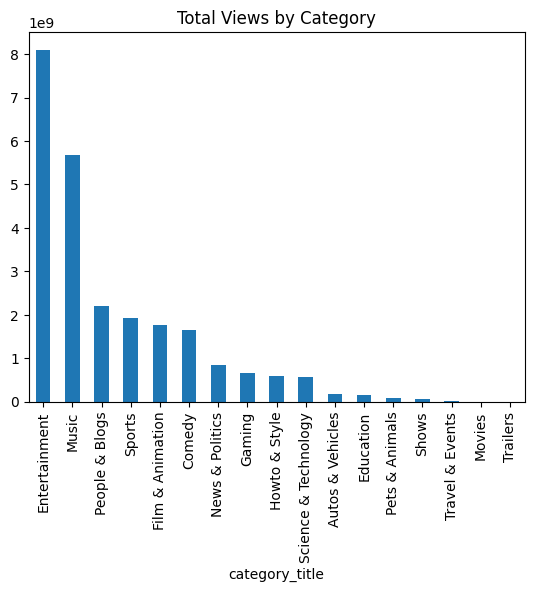

In [ ]:
# Bar plot for total views by category
views_by_category.plot(kind='bar', title='Total Views by Category')
plt.show()


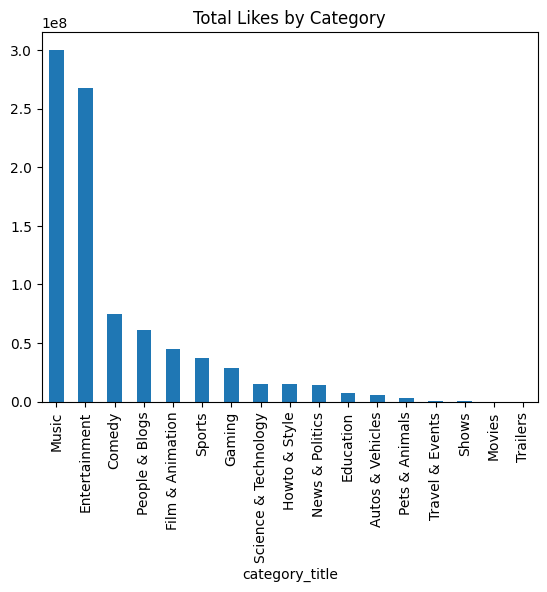

In [ ]:
# Bar plot for likes by category
likes_by_category.plot(kind='bar', title='Total Likes by Category')
plt.show()

### Top 5 channels with the most views and likes

We want to know which channels have the most popular videos by views and likes. We will group our data by channel_title and calculate sum of views and likes per channel_title. We will then plot the top 5 channels with the most views and the top 5 channels with the most likes.

In [ ]:
# We set the index to the channel_title column
data = DE.set_index(DE['channel_title'])
# We group by the channel_title and sum the views and likes
views_likes_by_channel = data.groupby(data.index)[['views', 'likes']].sum()
# We sort the values in descending order by views
views_sorted = views_likes_by_channel.sort_values(ascending=False, by='views')
# We sort the values in descending order by likes
likes_sorted = views_likes_by_channel.sort_values(ascending=False, by='likes')

display(views_sorted.head(5))  # We display the top 5 values sorted by views
display(likes_sorted.head(5))  # We display the top 5 values sorted by likes


views     likes
channel_title                            
Marvel Entertainment  585900476  20329272
Dude Perfect          408515774  17098702
ibighit               368806027  37863589
YouTube Spotlight     368298641  10771680
PewDiePie             307554426  23176561

views     likes
channel_title                            
ibighit               368806027  37863589
PewDiePie             307554426  23176561
Marvel Entertainment  585900476  20329272
Dude Perfect          408515774  17098702
Ed Sheeran            205159549  11576911

In [ ]:
# We subset the data to only include the top 5 channels by views
top_five_views = views_sorted.head(5)
top_five_views

views     likes
channel_title                            
Marvel Entertainment  585900476  20329272
Dude Perfect          408515774  17098702
ibighit               368806027  37863589
YouTube Spotlight     368298641  10771680
PewDiePie             307554426  23176561

In [ ]:
# We subset the data to only include the top 5 channels by likes
top_five_likes = likes_sorted.head(5)
top_five_likes

views     likes
channel_title                            
ibighit               368806027  37863589
PewDiePie             307554426  23176561
Marvel Entertainment  585900476  20329272
Dude Perfect          408515774  17098702
Ed Sheeran            205159549  11576911

In [ ]:
# Another way to find the channel with the most views is to use the idxmax() method
# First we calculate the total views by channel
views_by_channel = DE.groupby('channel_title')['views'].sum()

# Then get the channel with the most views using the idxmax() method
channel_with_most_views = views_by_channel.idxmax()
channel_with_most_views


'Marvel Entertainment'

In [ ]:
# We can do the same for the channel with the most likes
# Calculate the total likes by channel
likesby_channel = DE.groupby('channel_title')['likes'].sum()

# Then get the channel with the most views
channel_with_most_likes = likesby_channel.idxmax()
channel_with_most_likes


'ibighit'

### Plotting the top 5 channels with the most views and the top 5 channels with the most likes

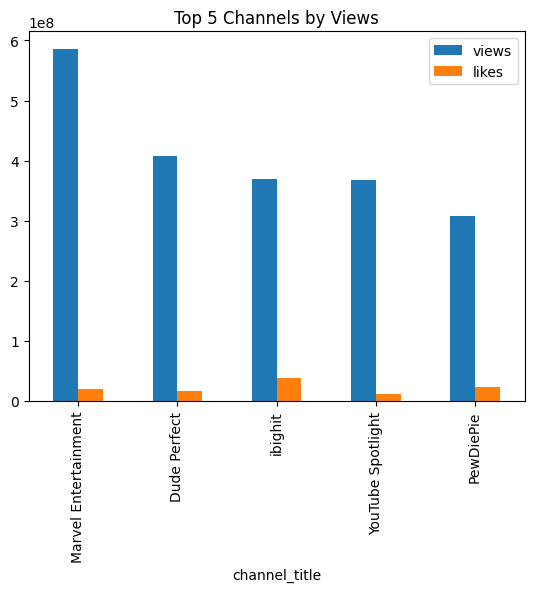

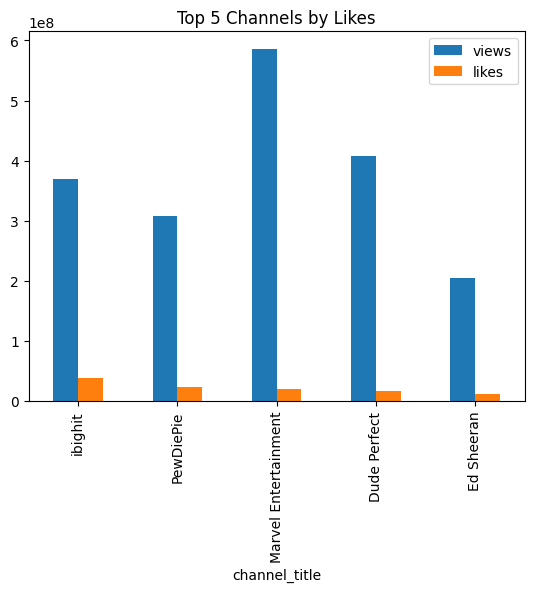

In [ ]:
# We create bar plot for the channels with the most views
top_five_views.plot(kind='bar', title='Top 5 Channels by Views')
# Similarly, we create a bar plot for the channels with the most likes
top_five_likes.plot(kind='bar', title='Top 5 Channels by Likes')
plt.show()


# Step 4: Text Analysis
In Step 4, the focus shifts to text analysis, where the process begins with data cleaning by removing special characters and converting letters to lowercase. Subsequently, tokenization is performed, followed by the removal of stopwords. <br>
The primary objectives of this step are to identify the most common words used in video titles and to analyze their sentiment, determining whether the titles convey a positive, negative, or neutral tone. This analysis aims to shed light on potential trends or patterns in popular video titles.

In [ ]:
# Text data analysis
# We extract all the columns with text data in a new dataframe
text_analysis = DE.loc[:, ['title', 'channel_title', 'tags']]
text_analysis
# text_analysis=text_analysis.apply(lambda x:x.astype('str').str.lower())

title  \
publish_time                                                                   
2012-04-18 12:58:15+02:00  Kriminelle Gro√üfamilien in Berlin - Interview ...   
2014-01-20 00:13:43+01:00                  Wrigley's Doublemint Werbung 1992   
2014-01-29 15:17:52+01:00                      Garish - Bring mich auf Ideen   
2014-01-29 15:17:52+01:00                      Garish - Bring mich auf Ideen   
2014-05-22 22:04:27+02:00  Hey Brother performed by Dan Tyminski and Jerr...   
...                                                                      ...   
2018-06-14 00:02:01+02:00  Acun Ilƒ±calƒ± √∂d√ºl√º a√ßƒ±klayƒ±nca √ßƒ±lgƒ±na d√∂nd√ºle...   
2018-06-14 01:34:13+02:00  ŸÖÿ≥ŸÑÿ≥ŸÑ ÿ±ÿ≠ŸäŸÖ ÿßŸÑÿ≠ŸÑŸÇÿ© 29 ÿßŸÑÿ™ÿßÿ≥ÿπÿ© ŸàÿßŸÑÿπÿ¥ÿ±ŸàŸÜ - ÿ®ÿ∑ŸàŸÑÿ© ...   
2018-06-14 01:53:29+02:00        –í–µ—á–µ—Ä —Å –í–ª–∞–¥–∏–º–∏—Ä–æ–º –°–æ–ª–æ–≤—å–µ–≤—ã–º –æ—Ç 13.06.2018   
2018-06-14 02:00:03+02:00      BLACKPINK - ‚ÄòÎöúÎëêÎöúÎëê (DDU-DU DDU-DU)‚Äô M/V TEASER   
2018-06-14 02:33:42+02:00  Kija SRAVNILA Lunu SA ZEMLJOM: Devojko, ti si ...   

                                  channel_title  \
publish_time                                      
2012-04-18 12:58:15+02:00  GehirnerweichungNein   
2014-01-20 00:13:43+01:00            RetroSpots   
2014-01-29 15:17:52+01:00                  OMhA   
2014-01-29 15:17:52+01:00                  OMhA   
2014-05-22 22:04:27+02:00            Alex Lewis   
...                                         ...   
2018-06-14 00:02:01+02:00             Acunn.com   
2018-06-14 01:34:13+02:00   Egyptian Arts Group   
2018-06-14 01:53:29+02:00             –†–æ—Å—Å–∏—è 24   
2018-06-14 02:00:03+02:00             BLACKPINK   
2018-06-14 02:33:42+02:00            belgrade26   

                                                                        tags  
publish_time                                                                  
2012-04-18 12:58:15+02:00  Intensivt√§ter|"Islamisierung"|"T√ºrken"|"Berlin...  
2014-01-20 00:13:43+01:00  Werbung|"TV spot"|"Werbespot"|"commercial"|"pu...  
2014-01-29 15:17:52+01:00  Garish Trumpf|"Garish"|"Trumpf"|"Bring mich au...  
2014-01-29 15:17:52+01:00  Garish Trumpf|"Garish"|"Trumpf"|"Bring mich au...  
2014-05-22 22:04:27+02:00  Hey Brother|"Dan Tyminski (Record Producer)"|"...  
...                                                                      ...  
2018-06-14 00:02:01+02:00  survivor|"survivor 2018"|"Survivor 2018 12. se...  
2018-06-14 01:34:13+02:00  ŸÖÿ≥ŸÑÿ≥ŸÑ ÿ±ÿ≠ŸäŸÖ|"ÿ±ŸÖÿ∂ÿßŸÜ 2018"|"ŸÖÿ≥ŸÑÿ≥ŸÑÿßÿ™ ÿ±ŸÖÿ∂ÿßŸÜ 2018"|"...  
2018-06-14 01:53:29+02:00  –ø–æ–µ–¥–∏–Ω–æ–∫|"–º–∏—Ö–µ–µ–≤"|"–ø–æ–ª–Ω—ã–π –∫–æ–Ω—Ç–∞–∫—Ç"|"–≤–µ—á–µ—Ä —Å –≤–ª...  
2018-06-14 02:00:03+02:00                 Î∏îÎûôÌïëÌÅ¨|"BLACKPINK"|"Ïä§ÌÄòÏñ¥ÏóÖ"|"SQUAREUP"  
2018-06-14 02:33:42+02:00  estrada|"estradne vesti"|"najnovije estradne v...  

[40840 rows x 3 columns]

In [ ]:
# We remove the unnecessary characters using lambda, str.replace()
text_analysis = text_analysis.apply(lambda x: x.str.replace('[^\w\s]', ' ', regex=True))


In [ ]:
# Next, we tokenize the text using lower case text. We use the lambda function to apply the word_tokenize() function to each cell in the dataframe
token = text_analysis.applymap(lambda x: nltk.word_tokenize(str(x).lower()))
token


title  \
publish_time                                                                   
2012-04-18 12:58:15+02:00  [kriminelle, gro√üfamilien, in, berlin, intervi...   
2014-01-20 00:13:43+01:00            [wrigley, s, doublemint, werbung, 1992]   
2014-01-29 15:17:52+01:00                  [garish, bring, mich, auf, ideen]   
2014-01-29 15:17:52+01:00                  [garish, bring, mich, auf, ideen]   
2014-05-22 22:04:27+02:00  [hey, brother, performed, by, dan, tyminski, a...   
...                                                                      ...   
2018-06-14 00:02:01+02:00  [acun, ilƒ±calƒ±, √∂d√ºl√º, a√ßƒ±klayƒ±nca, √ßƒ±lgƒ±na, d...   
2018-06-14 01:34:13+02:00  [ŸÖÿ≥ŸÑÿ≥ŸÑ, ÿ±ÿ≠ŸäŸÖ, ÿßŸÑÿ≠ŸÑŸÇÿ©, 29, ÿßŸÑÿ™ÿßÿ≥ÿπÿ©, ŸàÿßŸÑÿπÿ¥ÿ±ŸàŸÜ, ÿ®...   
2018-06-14 01:53:29+02:00  [–≤–µ—á–µ—Ä, —Å, –≤–ª–∞–¥–∏–º–∏—Ä–æ–º, —Å–æ–ª–æ–≤—å–µ–≤—ã–º, –æ—Ç, 13, 06,...   
2018-06-14 02:00:03+02:00  [blackpink, ÎöúÎëêÎöúÎëê, ddu, du, ddu, du, m, v, teaser]   
2018-06-14 02:33:42+02:00  [kija, sravnila, lunu, sa, zemljom, devojko, t...   

                                     channel_title  \
publish_time                                         
2012-04-18 12:58:15+02:00   [gehirnerweichungnein]   
2014-01-20 00:13:43+01:00             [retrospots]   
2014-01-29 15:17:52+01:00                   [omha]   
2014-01-29 15:17:52+01:00                   [omha]   
2014-05-22 22:04:27+02:00            [alex, lewis]   
...                                            ...   
2018-06-14 00:02:01+02:00             [acunn, com]   
2018-06-14 01:34:13+02:00  [egyptian, arts, group]   
2018-06-14 01:53:29+02:00             [—Ä–æ—Å—Å–∏—è, 24]   
2018-06-14 02:00:03+02:00              [blackpink]   
2018-06-14 02:33:42+02:00             [belgrade26]   

                                                                        tags  
publish_time                                                                  
2012-04-18 12:58:15+02:00  [intensivt√§ter, islamisierung, t√ºrken, berlin,...  
2014-01-20 00:13:43+01:00  [werbung, tv, spot, werbespot, commercial, pub...  
2014-01-29 15:17:52+01:00  [garish, trumpf, garish, trumpf, bring, mich, ...  
2014-01-29 15:17:52+01:00  [garish, trumpf, garish, trumpf, bring, mich, ...  
2014-05-22 22:04:27+02:00  [hey, brother, dan, tyminski, record, producer...  
...                                                                      ...  
2018-06-14 00:02:01+02:00  [survivor, survivor, 2018, survivor, 2018, 12,...  
2018-06-14 01:34:13+02:00  [ŸÖÿ≥ŸÑÿ≥ŸÑ, ÿ±ÿ≠ŸäŸÖ, ÿ±ŸÖÿ∂ÿßŸÜ, 2018, ŸÖÿ≥ŸÑÿ≥ŸÑÿßÿ™, ÿ±ŸÖÿ∂ÿßŸÜ, 201...  
2018-06-14 01:53:29+02:00  [–ø–æ–µ–¥–∏–Ω–æ–∫, –º–∏—Ö–µ–µ–≤, –ø–æ–ª–Ω—ã–π, –∫–æ–Ω—Ç–∞–∫—Ç, –≤–µ—á–µ—Ä, —Å, ...  
2018-06-14 02:00:03+02:00                  [Î∏îÎûôÌïëÌÅ¨, blackpink, Ïä§ÌÄòÏñ¥ÏóÖ, squareup]  
2018-06-14 02:33:42+02:00  [estrada, estradne, vesti, najnovije, estradne...  

[40840 rows x 3 columns]

In [ ]:
# Now we have the dataframe tokenized. We can get the frequency of the tokens using nltk.FreqDist() function
tokens = []
for row in token['title']:
    tokens += row

fdist = nltk.FreqDist(tokens)
display(fdist.most_common(20))


[('2018', 5262),
 ('die', 3175),
 ('b√∂l√ºm', 2722),
 ('der', 2646),
 ('1', 2480),
 ('2', 2426),
 ('the', 2415),
 ('in', 2263),
 ('mit', 2200),
 ('und', 1912),
 ('2017', 1885),
 ('video', 1541),
 ('official', 1534),
 ('vs', 1460),
 ('3', 1417),
 ('f√ºr', 1413),
 ('das', 1404),
 ('s', 1370),
 ('18', 1288),
 ('auf', 1232)]

In [ ]:
# The most common words used are meaningless words so we remove them using stopwords()
# We will combine stopwords from multiple sources, for the english and german language
# We also remove any numbers from the text

# list of stop words from one library
stop_words = list(get_stop_words('en'))
# list of stop words from another library
nltk_words = list(stopwords.words('english'))
# add german stopwords
nltk_words_de = list(stopwords.words('german'))
# we add some stopwords from another library
stop_words.extend(nltk_words)
# we add the german language as well
stop_words.extend(nltk_words_de)
# we add some words that we think are not relevant but are very common
added_words = ['and', 'video', 'vs']
# Add the extra words to the stop_words list
stop_words.extend(added_words)
# Convert each sublist to a tuple
token_tuples = [tuple(x) for x in token['title']]
# filtered_sentence = [w for w in token_tuples if w not in stop_words and not word.isnumeric()] # we can use this as well
filtered_sentence = []
for tup in token_tuples:
    for word in tup:
        if word not in stop_words and not word.isnumeric():
            filtered_sentence.append(word)


In [ ]:
# We can see the first 10 stopwords
print(stop_words[0:10])
# We can see the first 10 tokens from which we will remove the stopwords
print(token_tuples[0:10])
# We can see the first 10 tokens after removing the stopwords
print(filtered_sentence[0:10])


['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']
[('kriminelle', 'gro√üfamilien', 'in', 'berlin', 'interview', 'mit', 'arnold', 'mengelkoch', 'april', '2012'), ('wrigley', 's', 'doublemint', 'werbung', '1992'), ('garish', 'bring', 'mich', 'auf', 'ideen'), ('garish', 'bring', 'mich', 'auf', 'ideen'), ('hey', 'brother', 'performed', 'by', 'dan', 'tyminski', 'and', 'jerry', 'douglas'), ('amadeus', 'soszka', 's√§nger'), ('dan', 'tyminski', 'hey', 'brother', 'live'), ('amazing', 'plane', 'landing', 'surprise'), ('imsr', 'fly', 'by'), ('touch', 'me', 'not', 'teaser', 'trailer')]
['kriminelle', 'gro√üfamilien', 'berlin', 'interview', 'arnold', 'mengelkoch', 'april', 'wrigley', 'doublemint', 'werbung']


In [ ]:
# Calculate the total number of tokens in token_tuples before filtering stopwords
tokens_before_filtering = sum(len(tup) for tup in token_tuples)

# Calculate the total number of tokens in filtered_sentence after filtering stopwords
tokens_after_filtering = len(filtered_sentence)

print("Total tokens before filtering stopwords:", tokens_before_filtering)
print("Total tokens after filtering stopwords:", tokens_after_filtering)

Total tokens before filtering stopwords: 360322
Total tokens after filtering stopwords: 258447


### Calculate and plot the frequency distribution for the most common words used in the video titles


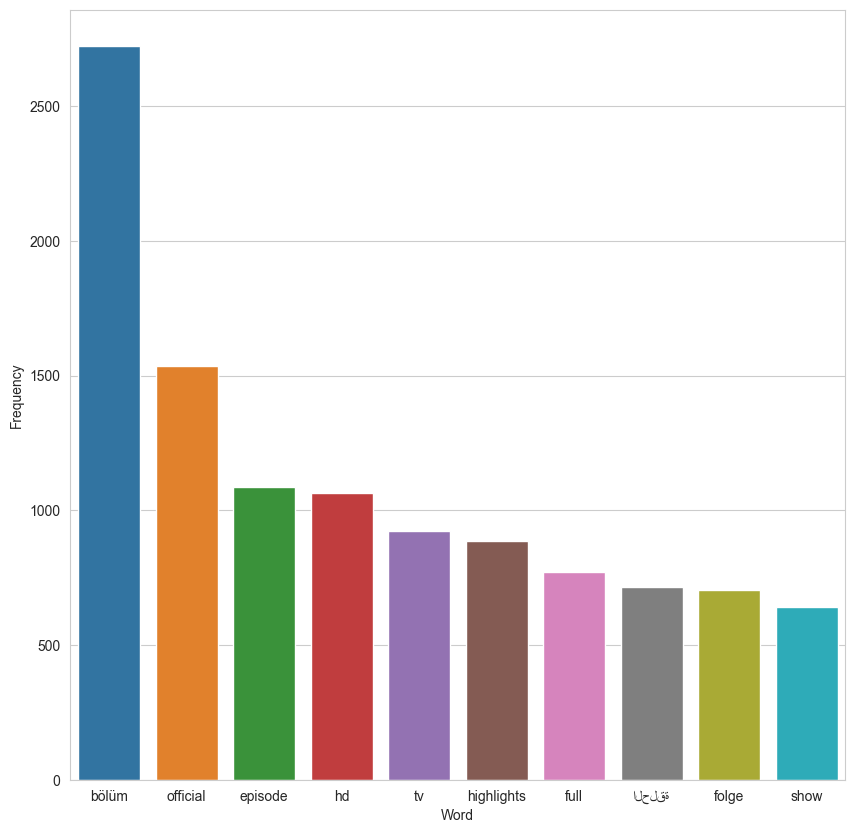

In [ ]:
top = 10
word_dist = nltk.FreqDist(numeric)
result = pd.DataFrame(word_dist.most_common(top),
                      columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word", y="Frequency", data=result.head(10))


### Sentiment Analysis

In [ ]:
# We can use the TextBlob library to calculate the sentiment of the text in the titles
listing = []
token1 = token['title']
for word in token_tuples[0:100]:
    for word1 in word:
        blob = TextBlob(word1)
        listing.append((row, blob.sentiment.polarity,
                       blob.sentiment.subjectivity))
        exp = pd.DataFrame(listing, columns=[
                           'word', 'sentiment', 'positivity'])


In [ ]:
# We classify the sentiment of the words into positive, negative and neutral
def f(exp):
    if exp['sentiment'] > 0:
        val = "Positive"
    elif exp['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val


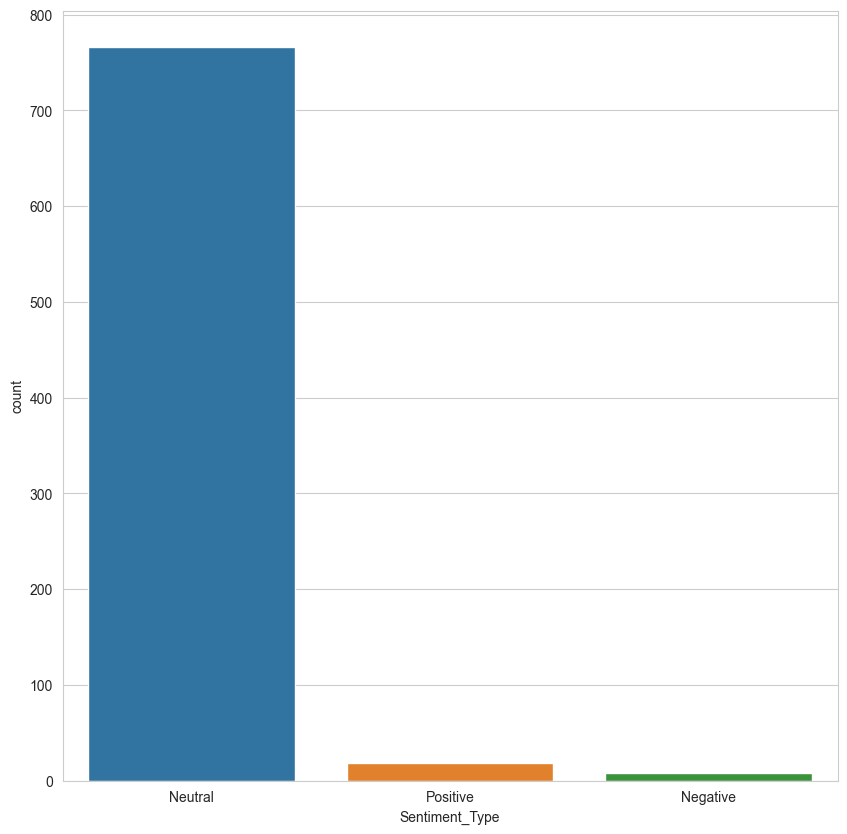

In [ ]:
# We apply the function to the dataframe and plot the results
exp['Sentiment_Type'] = exp.apply(f, axis=1)

plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=exp)


# Analysis Summary:

The data analysis of the project reveals that the most popular videos are predominantly TV show episodes, particularly from "The Late Show with Stephen Colbert," available in various languages. The top five categories overall, based on likes, include Entertainment, Music, People & Blogs, Film & Animation, and Comedy, while Sports is a major category in terms of views. A positive correlation is observed between the number of views and likes for a video. Moreover, post-2018, the gap between a video's trending date and its publishing date has significantly decreased, suggesting that YouTube has gained popularity among people in Germany since 2018.

# Import the dataset to a table in Azure sql and then connect to the azure sql by pyodbc library 
[Not yet working, had some issues with drivers]

In [ ]:
from queue import Queue
from threading import Lock
import pyodbc
from getpass import getpass
import pandas as pd

server = 'trainingtestc339.database.windows.net'
database = 'trainingtest'
username = 'c339'
# password = getpass('Rovy0191654747.')
password = 'Rovy0191654747.'
# here make sure that you have the driver version, otherwise install it from microsoft
driver = '{ODBC Driver 17 for SQL Server}'
# https://learn.microsoft.com/en-us/sql/connect/odbc/download-odbc-driver-for-sql-server?view=sql-server-ver16
connection_string = f"DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}"
max_con = 50
connection_pool = Queue(max_con)
lock = Lock()


# create connections and add them to the queue
for i in range(max_con):
    connection_pool.put(pyodbc.connect(connection_string))


# define a function to get connection from queue
def get_Connection():
    with lock:
        if not connection_pool.empty():
            return connection_pool.get()
    # if queue is empty, raise an exception
    raise Exception("Maximum number of connections reached")


def release_connection(connection):
    with lock:
        connection_pool.put(connection)


DE = pd.read_csv(
    'data sets\\data analysis project\\data\\youtube_data\\DEvideos.csv', error_bad_lines=False)
DE = pd.DataFrame(DE)
# Replace missing values with NULL
DE = DE.where(pd.notnull(DE), None)
# connection=get_Connection()
# cursor=connection.cursor()

# cursor.execute('select * from DE')  # query to call the database
for i, row in DE.iterrows():

    connection = get_Connection()
    cursor = connection.cursor()
    sql = "INSERT INTO DE (video_id,trending_date ,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description1) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
    val = tuple(row.values)

    cursor.execute(sql, val)
    connection.commit()
    cursor.close()

    release_connection(connection)


ImportError: dlopen(/opt/homebrew/lib/python3.11/site-packages/pyodbc.cpython-311-darwin.so, 0x0002): symbol not found in flat namespace '_SQLAllocHandle'

# Write the data to a SQLite database
Finally, we write the data to a SQLite database and run some queries on it.

In [ ]:
import sqlite3
from sqlite3 import Error
import pandas as pd

# Function to create a SQLite connection
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(f"SQLite connection created: {db_file}")
    except Error as e:
        print(e)
    return conn


# Define the SQLite database file
sqlite_file = "data/DE_videos.db"

# Create the SQLite connection
conn = create_connection(sqlite_file)

# Upload the 'DE' DataFrame to the SQLite database
DE.to_sql("DE_videos", conn, if_exists="replace", index=False)

# Close the connection
conn.close()

### Execute some queries on the SQLite database
#### 1. Select the first 10 rows from the DE_videos table

In [ ]:
conn = create_connection(sqlite_file)

query1 = "SELECT * FROM DE_videos LIMIT 10;"
result1 = pd.read_sql_query(query1, conn)

conn.close()

display(result1)

SQLite connection created: data/DE_videos.db


video_id              trending_date  \
0  FXA937WRDk0  2017-11-24 01:00:00+01:00   
1  -qdeWp22Rzo  2018-01-26 01:00:00+01:00   
2  maU5rLgMvWI  2018-01-31 01:00:00+01:00   
3  maU5rLgMvWI  2018-01-30 01:00:00+01:00   
4  45L82cOjfY0  2018-02-06 01:00:00+01:00   
5  zW9TgXJjfBY  2018-01-07 01:00:00+01:00   
6  v7dl3SHUZmQ  2018-02-06 01:00:00+01:00   
7  8a3TEOAEfcY  2017-11-15 01:00:00+01:00   
8  4bFe8Eqrjio  2017-11-16 01:00:00+01:00   
9  qXWIxiwNhqY  2018-02-24 01:00:00+01:00   

                                               title  \
0  Kriminelle Gro√üfamilien in Berlin - Interview ...   
1                  Wrigley's Doublemint Werbung 1992   
2                      Garish - Bring mich auf Ideen   
3                      Garish - Bring mich auf Ideen   
4  Hey Brother performed by Dan Tyminski and Jerr...   
5                           Amadeus Soszka -  S√§nger   
6                    Dan Tyminski - Hey Brother Live   
7                  Amazing plane landing - surprise!   
8                                        IMSR Fly-By   
9                      Touch Me Not - Teaser Trailer   

               channel_title  category_id  \
0       GehirnerweichungNein           25   
1                 RetroSpots            1   
2                       OMhA           10   
3                       OMhA           10   
4                 Alex Lewis           10   
5             Amadeus Soszka           22   
6           Allison Thompson           22   
7  IT Venture Partners & Co.            2   
8         Terrestrial Energy           28   
9                   Ytheatre           24   

                                                tags  views  likes  dislikes  \
0  Intensivt√§ter|"Islamisierung"|"T√ºrken"|"Berlin...  11373     90         1   
1  Werbung|"TV spot"|"Werbespot"|"commercial"|"pu...   2825     25         0   
2  Garish Trumpf|"Garish"|"Trumpf"|"Bring mich au...  54824    266         9   
3  Garish Trumpf|"Garish"|"Trumpf"|"Bring mich au...  51278    225         9   
4  Hey Brother|"Dan Tyminski (Record Producer)"|"...  99463    496        13   
5  Singing (Musical Instrument)|"Piano (Musical I...  29195    296       546   
6                                             [none]  33549    147        17   
7  plane|"famous24"|"Amazing plane landing - surp...   2909     73         0   
8                                             [none]   7145     15         1   
9                                                YTG  16764      3        13   

   comment_count                                  thumbnail_link  \
0              6  https://i.ytimg.com/vi/FXA937WRDk0/default.jpg   
1             10  https://i.ytimg.com/vi/-qdeWp22Rzo/default.jpg   
2             11  https://i.ytimg.com/vi/maU5rLgMvWI/default.jpg   
3              8  https://i.ytimg.com/vi/maU5rLgMvWI/default.jpg   
4             24  https://i.ytimg.com/vi/45L82cOjfY0/default.jpg   
5            232  https://i.ytimg.com/vi/zW9TgXJjfBY/default.jpg   
6             18  https://i.ytimg.com/vi/v7dl3SHUZmQ/default.jpg   
7              0  https://i.ytimg.com/vi/8a3TEOAEfcY/default.jpg   
8              2  https://i.ytimg.com/vi/4bFe8Eqrjio/default.jpg   
9              1  https://i.ytimg.com/vi/qXWIxiwNhqY/default.jpg   

   comments_disabled  ratings_disabled  video_error_or_removed  \
0                  0                 0                       0   
1                  0                 0                       0   
2                  0                 0                       0   
3                  0                 0                       0   
4                  0                 0                       0   
5                  0                 0                       0   
6                  0                 0                       0   
7                  0                 0                       0   
8                  0                 0                       0   
9                  0                 0                       0   

                                    

#### 2. Select the top 5 channels with the most views:

In [ ]:
conn = create_connection(sqlite_file)

query2 = """
SELECT channel_title, SUM(views) as total_views
FROM DE_videos
GROUP BY channel_title
ORDER BY total_views DESC
LIMIT 5;
"""
result2 = pd.read_sql_query(query2, conn)

conn.close()

print(result2)

SQLite connection created: data/DE_videos.db
          channel_title  total_views
0  Marvel Entertainment    585900476
1          Dude Perfect    408515774
2               ibighit    368806027
3     YouTube Spotlight    368298641
4             PewDiePie    307554426


#### 3. Select the 10 most liked videos

In [ ]:
conn = create_connection(sqlite_file)

query4 = """
SELECT title, channel_title, likes
FROM DE_videos
ORDER BY likes DESC
LIMIT 10;
"""
result4 = pd.read_sql_query(query4, conn)

conn.close()

display(result4)

SQLite connection created: data/DE_videos.db


title         channel_title  \
0                BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'FAKE LOVE' Official MV               ibighit   
1                BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'FAKE LOVE' Official MV               ibighit   
2                BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'FAKE LOVE' Official MV               ibighit   
3                BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'FAKE LOVE' Official MV               ibighit   
4  YouTube Rewind: The Shape of 2017 | #YouTubeRe...     YouTube Spotlight   
5  YouTube Rewind: The Shape of 2017 | #YouTubeRe...     YouTube Spotlight   
6  Marvel Studios' Avengers: Infinity War Officia...  Marvel Entertainment   
7  Childish Gambino - This Is America (Official V...   ChildishGambinoVEVO   
8  BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'MIC Drop (Steve Aoki Remix)' Offi...               ibighit   
9  Marvel Studios' Avengers: Infinity War Officia...  Marvel Entertainment   

     likes  
0  4924056  
1  4750254  
2  4470888  
3  3880074  
4  2811217  
5  2656675  
6  2513103  
7  2478908  
8  2454901  
9  2444956

#### 4. Find the average number of views, likes, and dislikes per video for each channel:

In [ ]:
conn = create_connection(sqlite_file)

query5 = """
SELECT channel_title, AVG(views) as avg_views, AVG(likes) as avg_likes, AVG(dislikes) as avg_dislikes
FROM DE_videos
GROUP BY channel_title;
"""
result5 = pd.read_sql_query(query5, conn)

conn.close()

display(result5)

SQLite connection created: data/DE_videos.db


channel_title     avg_views     avg_likes  \
0                                    #AndresSTyle  4.433970e+05   5461.333333   
1                               #Mentale Zuflucht  2.370058e+05   5140.065217   
2                                 #Mind Warehouse  1.580518e+06  22274.000000   
3                                         #WDR360  3.696875e+04   1144.625000   
4                                    (Fe)MaleASMR  3.654700e+04    957.000000   
...                                           ...           ...           ...   
6080  ÊπñÂçóÂç´ËßÜËäíÊûúTVÂÆòÊñπÈ¢ëÈÅì China HunanTV Official Channel  4.822512e+05   2602.200000   
6081                             ËÖæËÆØËßÜÈ¢ëTencentVideo  6.674360e+05   5345.000000   
6082                               È∫ªËæ£ÂèòÂΩ¢ËÆ° HOT GIRL  7.428900e+04     49.000000   
6083                       ÏòÅÍµ≠ÎÇ®Ïûê Korean Englishman  1.008725e+06  26383.000000   
6084                                           Ïö∞Ï∞å  2.190900e+05   1342.000000   

      avg_dislikes  
0       156.000000  
1      1083.445652  
2      1274.000000  
3       180.500000  
4        36.500000  
...            ...  
6080    328.133333  
6081    347.000000  
6082     15.000000  
6083   2649.500000  
6084    113.000000  

[6085 rows x 4 columns]

#### 5. Select the top 10 videos with the highest like to dislike ratio (ignoring videos with less than 1000 views to avoid outliers)

In [ ]:
conn = create_connection(sqlite_file)

query6 = """
SELECT title, channel_title, likes, dislikes, (1.0 * likes / dislikes) as like_dislike_ratio
FROM DE_videos
WHERE views > 1000
ORDER BY like_dislike_ratio DESC
LIMIT 10;
"""
result6 = pd.read_sql_query(query6, conn)

conn.close()

display(result6)

SQLite connection created: data/DE_videos.db


title    channel_title   likes  \
0               [MIXTAPE] I.M - Fly With Me (Teaser)       starshipTV   35338   
1                    Day6 Tomfoolery in NY and Japan           JaeSix   22743   
2  THE POPULAR DANCE TUTORIALS OF 90s-CURRENT W/B...           JaeSix   34756   
3                   Jackson Wang - Fendiman (Teaser)  JacksonWangVEVO   43504   
4                                     G.C.F in Osaka        BANGTANTV  688754   
5  ANDREW HUANG meets Marti Fischer live at #Bong...   BongoBoulevard    2740   
6                     Clash Royale Cheat | 100% free              God    7226   
7             1 Random Copic Marker üèÜ Challenge PLUS     KritzelPixel     829   
8  BTS Dish About Debuting New Music At The 2018 ...           Access   16371   
9  [PREVIEW] BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 2018 Season‚Äôs greetings ...        BANGTANTV  237301   

   dislikes  like_dislike_ratio  
0        25         1413.520000  
1        17         1337.823529  
2        28         1241.285714  
3        37         1175.783784  
4       687         1002.553130  
5         3          913.333333  
6         8          903.250000  
7         1          829.000000  
8        20          818.550000  
9       299          793.648829